# Modelling of birdsong learning as collective motion in parameter space (birdsong CMPS model)

__Author__: Tomas Tomka

__Date__:   March 8, 2025

__Objective__: Modelling of context-dependent vocal learning of song syllable features in songbirds. 

__Corresponding paper__: Tomka, T. 2025. Lifelong motor learning as collective motion in a space of gestures. arXiv.

### Data source:
* Warren et al., 2011 (https://doi.org/10.1152/jn.00311.2011): Figure 2C (congruent aversive learning, n=1) and Figure 5 (recovery, n=5).
* Tian & Brainard, 2017 (https://doi.org/10.1016/j.neuron.2017.10.019): Figure 2A (12 days selective training of a single context 1, followed by 5 days incongruent training of both contexts, n=1) 

### Collective motion in parameter space (CMPS) model for birsong learning:
We model the context-dependent learning and adaptation of birdsong syllables in adult birds as collective motion in motor parameter space. Motor parameters (learned neural properties) are assumed to map bijectively to motor feature space. I.e., a single acoustic feature such as pitch can be represented by a single representational motor parameter.
 
Let $x_1, x_2$ be motor representations of pitch trajectories (pitch measured in Hertz) of a given syllable in two different context. After the $t$-th rendition of the $i$-th context, we use the following updating rules:

$\Delta x_{i,t+1} = \alpha (g_{i,t} - x_{i,t})$,

$\Delta x_{j,t+1} = \alpha (g_{j,0} - x_{j,t}) + c_{ji}H(x_{i,t+1},x_{j,t})(x_{i,t}+\Delta x_{i,t+1}-x_{j,t}) , \forall j \neq i $

with $g_{i,t}=g_{i,0}$ for "escape" trials, and $g_{i,t}=x_{i,t}+\delta_{i}\beta $ for "hit" trials 
and the following parameters:

$g_{k,0}$ : long-term goal for $k=1,2$

$\alpha$ : drift-rate towards both long-term goals $g_{k,0}$ for $k=1,2$

$\beta$ : Aversive shift constant

$c_{ji}$ : coupling constant, modulating the attraction of $x_j$ towards $x_i$

$H$ is a negative Hill function that defines the distance-dependency of mutual attraction with 
* Hill coefficient $n$ and 
* Hill constant $d_{50}$.
  
Pitch renditions is modelled with two Gaussians centered at $x_{k,t}$ for $k=1,2$, with standard deviation $\sigma$. The daily pitch thresholds which define the boundary between "hit" and "escape" trials have been digitized from the source data and are given as a model input. The directionality of learning $\delta_{i}$ is given by the experimental setup, too.

For simplicity, we assume: 
* The birds sing each day a fixed sequence $s=\{1,2,1,2,...\}$ of rendititions in alternating contexts.
* There is only one coupling constant $c = c_{12} = c_{21}$.
* The directionality of learning can be computed by the bird's brain, e.g., with reinforcement models that infer a gradient from the history of previous trials. This inference has not been modelled explicitely.
* Reversion to the original pitch is only learnable from “escape” trials. This assumption is justified by the fact, that on “hit” trials the nearly instantaneous white noise distorts the acoustics of the targeted syllable rendition to a large degree.
* Wwo contexts underly the data from Warren et al., 2011 (authors have not discussed presence of different contexts).


We set $g_{k,0} = x_{k,0} = 0$ Hz for $k=1,2$ (learning as change from the baseline) and estimate $(\alpha, \beta, c)$ from the data of Tian & Brainard (2017). 

### Experimental motivation of the CMPS model:
* Juvenile songbirds can learn their song syllables hierarchically by splitting developmental trajectories of a syllable precursor in two different contexts (e.g. differentiating the precursor representations at a song bout edge from the rest).
* Adult songbirds can temporarily adapt context-dependent features of their birdsong syllables, when incentivized by aversive stimuli. Context-selective training is generalized to other contexts.

### Auxillary functions and settings

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import tol_colors as tc
import pickle as pkl
from copy import deepcopy

%reload_ext autoreload
%autoreload 2
%matplotlib inline

w = 18*0.3937   # page width
pt = 8          # font size
plt.rcParams.update({'legend.fontsize':pt, 
                     'axes.labelsize' : pt, 
                     'axes.linewidth' : 1,
                     'lines.linewidth': 3, 
                     'text.usetex': True, 
                     'ytick.labelsize': pt, 
                     'xtick.labelsize': pt,
                     'savefig.dpi': 300, 
                     'savefig.format':'png',
                     'figure.figsize': (0.3*w, 0.23*w)})

colors = {'x1': '#DDCC77',
          'x2': '#44AA99',
          'g': 'lightgrey',
          'H': '#CC6677',
          'spl': '#88CCEE',
          'transfer': 'c'}

root_path = 'C:/Users/Startklar/Dropbox/CollectiveMotionPaper'
os.chdir(root_path)
data_path_1 = './Warren2011/'
data_path_2 = './TianBrainard2017/'

np.random.seed(123)

In [2]:
# mutual local attraction modelled with Hill function
def Hill(x1, x2, n, d50):
    return 1 / (1 + (np.linalg.norm(x1 - x2)/d50)**n)

# simulate aversive learning for a system of 2 agents in 1 dimensional motor space
def simulate_aversive(x0, alpha, beta, c, n, d50, sd, thresh, seq, samples_per_day, direction):

    # initialize
    ttot = len(seq)
    xpre = deepcopy(x0)
    X = np.empty((ttot, 2))
    P = np.empty((ttot, 1))
    if len(thresh.shape)==2:
        # incongruent learning
        day_indices = np.hstack([x*np.ones((1, samples_per_day), dtype=int) for x in range(len(thresh[0]))])
    else:
        # congruent learning
        day_indices = np.hstack([x*np.ones((1, samples_per_day), dtype=int) for x in range(len(thresh))])

    # iterate over all renditions
    for t in range(ttot):

        # get active context and current threshold
        i = int(seq[t]) 
        day_index = day_indices[0, t]
        if len(thresh.shape)==2:
            # incongruent learning
            thresh_t = thresh[i, day_index]
        else:
            # congruent learning
            thresh_t = thresh[day_index]

        # determine pitch and whether it is a hit trial
        pitch = xpre[i] + np.random.normal(0, sd)
        P[t] = pitch
        if thresh_t == np.nan:
            ishit = False
        else:
            if direction[i]==1:
                ishit = pitch < thresh_t
            else:
                ishit = pitch > thresh_t

        # update representation of active context
        if ishit:
            # aversive learning
            X[t, i] = xpre[i] + direction[i]*alpha*beta 
        else:
            # reversion to the template
            X[t, i] = xpre[i] + alpha*(x0[i] - pitch) 

        # covert update
        for j in range(2):
            if j != i and np.linalg.norm(X[t, i] - xpre[j]) > 1e-10: # prevent infinitely small numbers
                H = Hill(X[t, i], xpre[j], n, d50)
                X[t, j] = xpre[j] + H*c*(X[t, i] - xpre[j])

        # previous = current representation 
        xpre = X[t, :]
    return P, X

# Cost function to fit model to congruent training data (Warren et al., 2011)
def cost_function_congruent(p, x0, c, n, d50, seq, samples_per_day, exp_mean, exp_sd, exp_thresh, rec_mean, direction):

    # estimated parameters
    alpha = p[0]
    beta = p[1]
    sd = p[2]

    # compute average over 100 simulations
    ndays = len(exp_thresh)
    n_sim = 100
    P_mean = np.empty((n_sim, ndays-3))
    P_sd = np.empty((n_sim, ndays-3))
    P_rec_mean = np.empty((n_sim, 3))
    
    for i in range(n_sim):
        
        # simulate
        P, X = simulate_aversive(x0, alpha, beta, c, n, d50, sd, exp_thresh_sim, seq, samples_per_day, direction)
        
        # compute simulated daily means and sd
        P_day = [P[x:x+samples_per_day] for x in range(0, len(P), samples_per_day)]
        P_mean[i,:] = np.array([np.mean(pd) for pd in P_day])[:-3]
        P_sd[i,:] = np.array([np.std(pd) for pd in P_day])[:-3]
        P_rec_mean[i,:] = np.array([np.mean(pd) for pd in P_day])[-3:]
    P_mean = np.mean(P_mean, axis=0)
    P_sd =  np.mean(P_sd, axis=0)
    P_rec_mean = np.mean(P_rec_mean, axis=0)
    
    # return loss function
    return sum((exp_mean - P_mean)**2) + sum((exp_sd - P_sd)**2) + sum((rec_mean - P_rec_mean)**2)

# Cost function to fit model to incongruent data (Tian & Brainard, 2017)
def cost_function_incongruent(p, seq, samples_per_day, exp_mean, exp_sd, exp_thresh, direction):

    # estimated parameters
    alpha = p[0]
    beta = p[1]
    c = p[2]
    n = p[3]
    d50 = p[4]
    x0 = p[5:7]
    sd = p[7]

    # compute average over 500 simulations
    ndays = len(exp_thresh[0])
    n_sim = 100
    P_mean_a = np.empty((n_sim, ndays))
    P_sd_a = np.empty((n_sim, ndays))
    P_mean_b = np.empty((n_sim, ndays))
    P_sd_b = np.empty((n_sim, ndays))
    
    for i in range(n_sim):
        
        # simulate
        P, X = simulate_aversive(x0, alpha, beta, c, n, d50, sd, exp_thresh, seq, samples_per_day, direction)
        
        # compute simulated daily means and sd
        P_a = P[0::2]
        P_b = P[1::2]
        P_day_a = [P_a[x:x+int(samples_per_day/2)] for x in range(0, len(P_a), int(samples_per_day/2))]
        P_day_b = [P_b[x:x+int(samples_per_day/2)] for x in range(0, len(P_b), int(samples_per_day/2))]
        P_mean_a[i,:] = np.array([np.mean(pd) for pd in P_day_a])
        P_mean_b[i,:] = np.array([np.mean(pd) for pd in P_day_b])
        P_sd_a[i,:] = np.array([np.std(pd) for pd in P_day_b])
        P_sd_b[i,:] = np.array([np.std(pd) for pd in P_day_b])
    P_mean_a = np.mean(P_mean_a, axis=0)
    P_sd_a = np.mean(P_sd_a, axis=0)
    P_mean_b = np.mean(P_mean_b, axis=0)
    P_sd_b = np.mean(P_sd_b, axis=0)
    
    # return loss function
    return (sum((exp_mean[0,:] - P_mean_a)**2) + sum((exp_mean[1,:] - P_mean_b)**2) + 
            sum((exp_sd[0,:] - P_sd_a)**2) + sum((exp_sd[1,:] - P_sd_b)**2))

### Import Warren et al. (2011) data

In [3]:
# Individual data from Figure 2C
D1 = pd.read_csv(data_path_1 + 'Fig2C.csv', sep=',', header=0, decimal='.', dtype= np.float32)
days = np.array(D1['Time'])
exp_mean = np.array(D1['Mean'] - D1['Mean'][0])*1000
exp_sd = np.array(D1['Upper'] - D1['Lower'])/2*1000
exp_thresh = np.array(D1['Threshold']- D1['Mean'][0])* 1000

# Population data on recovery phase from Figure 5
D2 = pd.read_csv(data_path_1 + 'Fig5.csv', sep=',', header=0, decimal='.', dtype= np.float32)
days_recovery = np.array(D2['RecoveryDay'])
rec_min = np.array(D2[['ID1','ID2','ID3','ID4','ID5']].min(axis=1))*exp_mean[-1]/100
rec_max = np.array(D2[['ID1','ID2','ID3','ID4','ID5']].max(axis=1))*exp_mean[-1]/100
rec_mean = np.array(D2[['ID1','ID2','ID3','ID4','ID5']].mean(axis=1))*exp_mean[-1]/100

### Simulate congruent learning based on Warren et al. (2011) data

In [4]:
# merge days and thresholds from learning and recovery period
days_sim = np.append(days, days_recovery + days[-1])
exp_thresh_sim = np.append(exp_thresh, np.nan*np.empty((1,3)))

# simulation time
samples_per_day = 100
tsim = samples_per_day * len(days_sim) 

# daily sequence of context renditions
# 0: context 'a', 1: context 'b'
seq = np.zeros(tsim,dtype=int)
seq[1::2] = 1 

# direction of learning towards higher pitch for both contexts
direction = [1, 1]

# fixed parameters
x0 = [0, 0] # baseline learning in Hz
c = 0       # cannot be estimated from congruent learning alone, thus fixed to 0
n = 4       # cannot be estimated from congruent learning alone, thus fixed shallow Hill function
d50 = 100   # cannot be estimated from congruent learning alone, thus fixed to 100 Hz 

# inital guess and bounds
p0 = [ 0.02, # alpha
      1200,  # beta
      40]    # sd 
bnds = ((0, 1),     # alpha
        (0, 2000),  # beta
        (20, 100))  # sd 

# fit 
out = minimize(cost_function_congruent, p0, 
               args=(x0, c, n, d50, seq, samples_per_day, exp_mean, exp_sd, exp_thresh_sim, rec_mean, direction), 
               bounds=bnds, method='Nelder-Mead', options={'maxiter': 20})
p=out.x    
print(out)

       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 1783.2007841881407
             x: [ 1.459e-02  7.829e+02  5.217e+01]
           nit: 20
          nfev: 37
 final_simplex: (array([[ 1.459e-02,  7.829e+02,  5.217e+01],
                       [ 1.399e-02,  6.441e+02,  5.545e+01],
                       [ 1.461e-02,  7.605e+02,  5.397e+01],
                       [ 1.384e-02,  7.383e+02,  5.459e+01]]), array([ 1.783e+03,  1.841e+03,  1.860e+03,  1.863e+03]))


In [5]:
# unpack estimated parameters
alpha = p[0]
beta = p[1]
sd = p[2]
print(alpha,beta,sd)

# compute average over 500 simulations
n_sim = 500
P_mean_a = np.empty((n_sim, len(days_sim)))
P_mean_b = np.empty((n_sim, len(days_sim)))
P_mean = np.empty((n_sim, len(days_sim)))
P_sd = np.empty((n_sim, len(days_sim)))
for i in range(n_sim):
    P, X = simulate_aversive(x0, alpha, beta, c, n, d50, sd, exp_thresh_sim, seq, samples_per_day, direction)
    P_a = P[0::2]
    P_b = P[1::2]
    P_day = [P[x:x+samples_per_day] for x in range(0, len(P), samples_per_day)]
    P_day_a = [P_a[x:x+int(samples_per_day/2)] for x in range(0, len(P_a), int(samples_per_day/2))]
    P_day_b = [P_b[x:x+int(samples_per_day/2)] for x in range(0, len(P_b), int(samples_per_day/2))]
    P_mean_a[i,:] = np.array([np.mean(pd) for pd in P_day_a])
    P_mean_b[i,:] = np.array([np.mean(pd) for pd in P_day_b])
    P_sd[i,:] = np.array([np.std(pd) for pd in P_day])
    P_mean[i,:] = np.array([np.mean(pd) for pd in P_day])
P_mean_a = np.mean(P_mean_a, axis=0)
P_mean_b = np.mean(P_mean_b, axis=0)
P_mean = np.mean(P_mean, axis=0)
P_sd = np.mean(P_sd, axis=0)


0.014588365406507951 782.852207488696 52.165106756911825


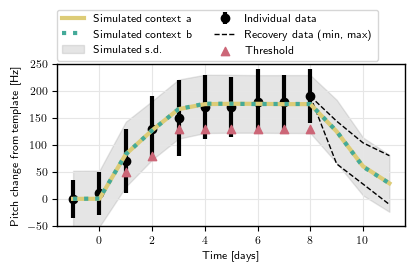

In [6]:
plt.figure(figsize=(0.6*w, 0.4*w))
plt.errorbar(days, exp_mean, exp_sd, fmt='o',
             color='black', label='Individual data')
plt.plot(np.append(days[-1], days_recovery + days[-1]), np.append(exp_mean[-1],rec_max), 
         lw=1, ls='--', color='black', label='Recovery data (min, max)', zorder=3)
plt.plot(np.append(days[-1], days_recovery + days[-1]), np.append(exp_mean[-1],rec_min),
         lw=1, ls='--', color='black', zorder=3)
plt.plot(days_sim, P_mean_a, 
         color=colors['x1'], label='Simulated context a',zorder=3)
plt.plot(days_sim, P_mean_b, 
         color=colors['x2'], label='Simulated context b', ls=':', zorder=3)
plt.fill_between(days_sim, P_mean - P_sd, P_mean + P_sd,
                 alpha=0.2, color='grey', linewidth=None, linestyle='-', 
                 label='Simulated s.d.')
plt.scatter(days, exp_thresh, 
            color=colors['H'], label= 'Threshold', marker='^', zorder=2)
plt.grid(which='both', color='0.9', linestyle='-')
plt.ylim([-50, 250])
plt.xlabel('Time [days]') 
plt.ylabel('Pitch change from template [Hz]') 
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 2, 3, 5, 0, 4]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
           bbox_to_anchor=(0, 1.02, 0.2, 0.2), loc="lower left", borderaxespad=0, ncol=2)

plt.tight_layout()
plt.savefig('figs/fig4_congruent')

### Import Tian & Brainard (2017) data

In [7]:
# Context a
D_a = pd.read_csv(data_path_2 + 'Fig2A_c1.csv', sep=',', header=0, decimal='.', dtype= np.float32)
days = np.array(D_a['Time'])
exp_mean_a = np.array(D_a['Mean'] - D_a['Mean'][0])
exp_sd_a = np.array(D_a['Upper'] - D_a['Lower'])/2
exp_thresh_a = np.array(D_a['Threshold']- D_a['Mean'][0])

# Context b
D_b = pd.read_csv(data_path_2 + 'Fig2A_c2.csv', sep=',', header=0, decimal='.', dtype= np.float32)
days = np.array(D_b['Time'])
exp_mean_b = np.array(D_b['Mean'] - D_a['Mean'][0])
exp_sd_b = np.array(D_b['Upper'] - D_b['Lower'])/2
exp_thresh_b = np.array(D_b['Threshold']- D_a['Mean'][0])
exp_thresh_b_ignored = deepcopy(exp_thresh_b[15:17])
exp_thresh_b[15] = np.nan
exp_thresh_b[16] = np.nan

exp_mean = np.vstack([exp_mean_a, exp_mean_b])
exp_sd = np.vstack([exp_sd_a, exp_sd_b])
exp_thresh = np.vstack([exp_thresh_a, exp_thresh_b])

In [8]:
# simulation time
samples_per_day = 100
tsim = samples_per_day * len(days) 

# daily sequence of context renditions
# 0: context 'a', 1: context 'b'
seq = np.zeros(tsim,dtype=int)
seq[1::2] = 1 

# direction of learning
direction = [1, # up for context a 
            -1] # down for context b

# inital guess and bounds
p0 = [0.02, # alpha
      1200, # beta
      0.01, # c
      10,   # n
      250,  # d50
      0,    # x0_a
      -30,  # x0_b
      45]   # sd
bnds = ((0, 1),      # alpha 
        (0, 2000),   # beta
        (0, 1),      # c
        (0, 100),    # n
        (0, 1000),   # d50
        (-100, 100), # x0_a
        (-100, 100), # x0_b
        (10, 100))   # sd

# fit 
out = minimize(cost_function_incongruent, p0, 
               args=(seq, samples_per_day, exp_mean, exp_sd, exp_thresh, direction), 
               bounds=bnds, method='Nelder-Mead', options={'maxiter': 5000})

p=out.x    
print(out)

       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 11431.090200564733
             x: [ 1.828e-02  9.906e+02  9.839e-03  1.037e+01  3.190e+02
                  6.782e-05 -2.851e+01  4.717e+01]
           nit: 5000
          nfev: 14191
 final_simplex: (array([[ 1.828e-02,  9.906e+02, ..., -2.851e+01,
                         4.717e+01],
                       [ 1.828e-02,  9.906e+02, ..., -2.851e+01,
                         4.717e+01],
                       ...,
                       [ 1.828e-02,  9.906e+02, ..., -2.851e+01,
                         4.717e+01],
                       [ 1.828e-02,  9.906e+02, ..., -2.851e+01,
                         4.717e+01]]), array([ 1.143e+04,  1.167e+04,  1.173e+04,  1.178e+04,
                        1.179e+04,  1.180e+04,  1.183e+04,  1.184e+04,
                        1.185e+04]))


In [9]:
# unpack estimated parameters
alpha = p[0]
beta = p[1]
c = p[2]
n = p[3]
d50 = p[4]
x0 = p[5:7]
sd = p[7]
print(alpha,beta,c,n,d50,x0,sd)
    
# compute average over 500 simulations
n_sim = 500
P_mean_a = np.empty((n_sim, len(days)))
P_sd_a = np.empty((n_sim, len(days)))
P_mean_b = np.empty((n_sim, len(days)))
P_sd_b = np.empty((n_sim, len(days)))
for i in range(n_sim):
    P, X = simulate_aversive(x0, alpha, beta, c, n, d50, sd, exp_thresh, seq, samples_per_day, direction)
    P_a = P[0::2]
    P_b = P[1::2]
    P_day_a = [P_a[x:x+int(samples_per_day/2)] for x in range(0, len(P_a), int(samples_per_day/2))]
    P_day_b = [P_b[x:x+int(samples_per_day/2)] for x in range(0, len(P_b), int(samples_per_day/2))]
    P_mean_a[i,:] = np.array([np.mean(pd) for pd in P_day_a])
    P_mean_b[i,:] = np.array([np.mean(pd) for pd in P_day_b])
    P_sd_a[i,:] = np.array([np.std(pd) for pd in P_day_b])
    P_sd_b[i,:] = np.array([np.std(pd) for pd in P_day_b])
P_mean_a = np.mean(P_mean_a, axis=0)
P_sd_a =  np.mean(P_sd_a, axis=0)
P_mean_b = np.mean(P_mean_b, axis=0)
P_sd_b =  np.mean(P_sd_b, axis=0)

0.01828449121523012 990.6337710143273 0.009838729369000754 10.37361263471433 319.01762133015666 [ 6.78155368e-05 -2.85067058e+01] 47.16944727416657


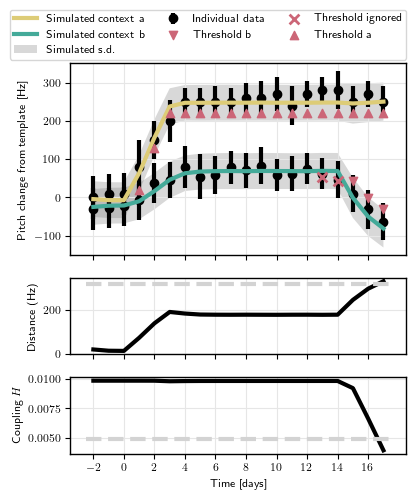

In [10]:
f, (a0, a1, a2) = plt.subplots(3, 1, height_ratios=[2.5, 1, 1], figsize=(0.6*w, 0.72*w), sharex=True)
a0.errorbar(days, exp_mean[0], exp_sd[0], fmt='o',
             color='black', label='Individual data')
a0.errorbar(days, exp_mean[1], exp_sd[1], fmt='o',color='black')
a0.plot(days, P_mean_a, 
         color=colors['x1'], label='Simulated context a', zorder=3)
a0.plot(days, P_mean_b, 
         color=colors['x2'], label='Simulated context b', zorder=3)
a0.fill_between(days, P_mean_a - P_sd_a, P_mean_a + P_sd_a,
                 alpha=0.3, facecolor='grey', linewidth=None, 
                 label='Simulated s.d.')
a0.fill_between(days, P_mean_b - P_sd_b, P_mean_b + P_sd_b,
                 alpha=0.3, facecolor='grey', linewidth=None)
a0.scatter(days, exp_thresh[0], 
            color=colors['H'], label= 'Threshold a', marker='^', zorder=10)
a0.scatter(days, exp_thresh[1], 
            color=colors['H'], label= 'Threshold b', marker='v', zorder=10)
a0.scatter(days[15:17], exp_thresh_b_ignored, s=50, lw=2,
            color=colors['H'], label= 'Threshold ignored', marker='x', zorder=10)
a0.grid(which='both', color='0.9', linestyle='-')
a0.set_ylim([-150, 350])
a0.set_ylabel('Pitch change from template [Hz]') 
handles, labels = a0.get_legend_handles_labels()
order = [0, 1, 2, 6, 4, 5, 3]
a0.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
           bbox_to_anchor=(-0.18, 1.02, 1.18, 1), loc="lower left", mode="expand", borderaxespad=0, ncol=3)

hill = deepcopy(P_mean_a)
for i in range(len(P_mean_a)):
    hill[i] = Hill(P_mean_a[i],P_mean_b[i], n, d50)
a1.plot(days, P_mean_a-P_mean_b, 
         color='black')
a1.grid(which='both', color='0.9', linestyle='-')
a1.set_ylabel('Distance (Hz)')
a1.hlines(d50,-2.5, 17.5, ls='--', color='lightgrey')
a2.plot(days, c*hill, color='black')
a2.grid(which='both', color='0.9', linestyle='-')
a2.hlines(c/2,-2.5, 17.5, ls='--', color='lightgrey')
a2.set_ylabel('Coupling $H$') 
a2.set_xlabel('Time [days]') 
a2.set_xticks(np.arange(-2,18,2)) 
f.tight_layout()
plt.savefig('figs/fig4_incongruent')